In [4]:
!pip install kaggle --upgrade

     |████████████████████████████████| 63 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 19.0 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77722 sha256=abd4494bbdb78be1b4bfc74d7acd55fe67bae749d082d353b88f70aaecb2be09
  Stored in directory: /Users/hwangseoyeon/Library/Caches/pip/wheels/e6/8e/67/e07554a720a493dc6b39b30488590ba92ed45448ad0134d253
Successfully built kaggle


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!ls -1ha kaggle.json

kaggle.json


In [9]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

100%|███████████████████████████████████████▉| 285M/285M [00:29<00:00, 10.1MB/s]
100%|████████████████████████████████████████| 285M/285M [00:29<00:00, 10.3MB/s]


In [1]:
import math
import numpy as np
import pandas as pd

#import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [2]:
import zipfile
import os
import pandas as pd

zip_file_path = 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip'

extracted_dir = 'Emotion Recognition'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Find the extracted CSV file
csv_file = None
for file in os.listdir(extracted_dir):
    if file.endswith('.csv'):
        csv_file = os.path.join(extracted_dir, file)
        break

if csv_file is not None:
    data = pd.read_csv(csv_file)
    print(f'Successfully read the CSV file: {csv_file}')
else:
    print('No CSV file found in the extracted folder.')

Successfully read the CSV file: Emotion Recognition/icml_face_data.csv


In [3]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
print(emotions)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
from keras.utils import to_categorical
def parse_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))
        image_array[i] = image
        
    return image_array, image_label

train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PublicTest"])

print("train shape", np.shape(train_imgs))
print("validation shape", np.shape(val_imgs))
print("validatio shape", np.shape(val_imgs))

train shape (28709, 48, 48, 1)
validation shape (3589, 48, 48, 1)
validatio shape (3589, 48, 48, 1)


In [7]:
train_images = train_imgs.reshape((train_imgs.shape[0], 48, 48, 1))
#train_images = train_images.astype('float32')//255.0
val_images = val_imgs.reshape((val_imgs.shape[0], 48, 48, 1))
#val_images = val_images.astype('float32')//255.0
test_images = test_imgs.reshape((test_imgs.shape[0], 48, 48, 1))
#test_images = test_images.astype('float32')//255.0

train_labels = to_categorical(train_lbls)
val_labels = to_categorical(val_lbls)
test_labels = to_categorical(test_lbls)

In [38]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

train_generator = datagen.flow(
    x=train_images,  
    y=train_labels,  
    batch_size=64,
    shuffle=False)

val_generator = datagen.flow(
    x=val_images,  
    y=val_labels ,  
    batch_size=64,
    shuffle=False)

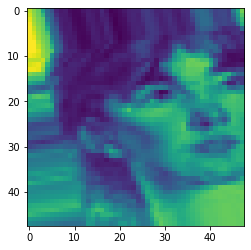

(48, 48, 1)

In [39]:
import matplotlib.pyplot as plt

# Get the first batch of images and labels from the validation generator
batch_images, batch_labels = next(train_generator)

# Plot the first image in the batch
plt.imshow(batch_images[31])
plt.show()

batch_images[1].shape

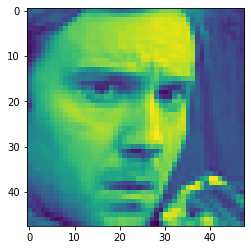

In [40]:
import matplotlib.pyplot as plt

plt.imshow(train_imgs[0])

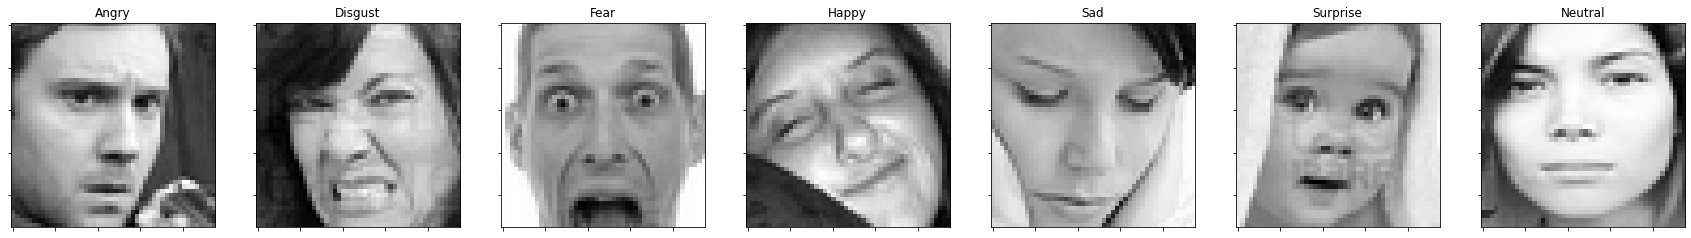

In [41]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

plot_all_emotions()

In [42]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

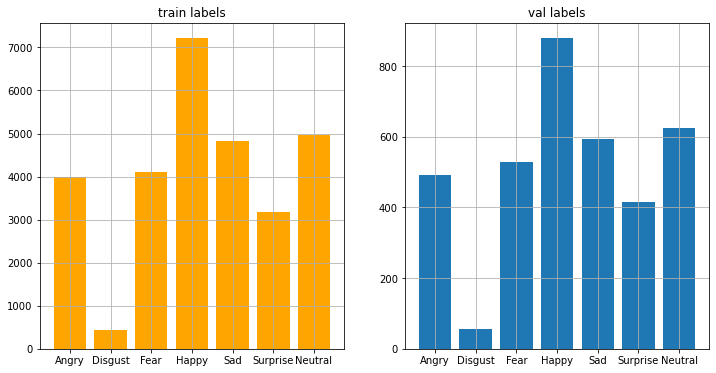

In [43]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential()

# 첫번째 Convolution layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 두번째 Convolution layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 세번째 Convolution layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_85 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_68 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_86 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                     

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint('emotion_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[checkpoint])

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.9275 - accuracy: 0.2444
Epoch 1: val_loss improved from inf to 1.87911, saving model to model.h5
448/448 [==============================] - 226s 497ms/step - loss: 1.9275 - accuracy: 0.2444 - val_loss: 1.8791 - val_accuracy: 0.2517
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.7284 - accuracy: 0.3123
Epoch 2: val_loss improved from 1.87911 to 1.65965, saving model to model.h5
448/448 [==============================] - 208s 465ms/step - loss: 1.7284 - accuracy: 0.3123 - val_loss: 1.6596 - val_accuracy: 0.3376
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.5336 - accuracy: 0.4034
Epoch 3: val_loss improved from 1.65965 to 1.51057, saving model to model.h5
448/448 [==============================] - 194s 434ms/step - loss: 1.5336 - accuracy: 0.4034 - val_loss: 1.5106 - val_accuracy: 0.4090
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.4288 - a

Epoch 29/50
448/448 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.6392
Epoch 29: val_loss improved from 1.02337 to 1.01361, saving model to model.h5
448/448 [==============================] - 186s 415ms/step - loss: 0.9672 - accuracy: 0.6392 - val_loss: 1.0136 - val_accuracy: 0.6161
Epoch 30/50
448/448 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.6402
Epoch 30: val_loss did not improve from 1.01361
448/448 [==============================] - 186s 415ms/step - loss: 0.9625 - accuracy: 0.6402 - val_loss: 1.0318 - val_accuracy: 0.6088
Epoch 31/50
448/448 [==============================] - ETA: 0s - loss: 0.9531 - accuracy: 0.6429
Epoch 31: val_loss did not improve from 1.01361
448/448 [==============================] - 187s 417ms/step - loss: 0.9531 - accuracy: 0.6429 - val_loss: 1.0909 - val_accuracy: 0.6027
Epoch 32/50
448/448 [==============================] - ETA: 0s - loss: 0.9459 - accuracy: 0.6475
Epoch 32: val_loss improved from 

In [53]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 5s 45ms/step - loss: 1.0101 - accuracy: 0.6397
test caccuracy: 0.6397325396537781
